# Examples of Prior Model Knowledge and Poorly adjusted Samples 


In this notebook, we expore how much the model actually uses the encoded data of the current time series. 
The notebook is organized in three steps

1. we initialize and train a LSTM on the germany dataset
2. we show two test examples. One that is predicted well a). another that is predicted poorly b).
3. we analyze the poorly example and predict using different seen data points from the same time series. We compare to the dataset and find that the model rather predicts the dataset mean+std than the actual seen data

## 1a. Setup

In [15]:
%%bash
# note this is not strictly necessary. models can be retrained from scratch in no time
if [ ! -d "/tmp/models" ]; then
  wget -nc -P /tmp https://syncandshare.lrz.de/dl/fi5Y1ZUyaY38NLXSzbbynDmA/models.tar.gz
  tar -xzf /tmp/models.tar.gz -C /tmp --keep-new-files
fi

In [1]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions, predict_future
from dataset import transform_data
from copy import deepcopy

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 1
hidden_size = 16
region = "germany"
epochs = 4
include_time = True # include time False works as well, but leads to models runing out of phase...

N_seen_points = 227
N_predictions = 100

def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

def setup(smooth, smooth_method="mean"):
    model = Model(input_size=1 if not include_time else 2,
                  hidden_size=hidden_size,
                  num_layers=num_layers,
                  output_size=1,
                  device=device)

    #model.load_state_dict(torch.load("/tmp/model_epoch_0.pth")["model"])
    model.train()

    enddate = None#'2010-01-01'

    dataset = ModisDataset(region=region,
                           fold="train",
                           znormalize=True,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,enddate),
                           smooth=smooth,
                           smooth_method=smooth_method)

    testdataset = ModisDataset(region=region,
                           fold="test",
                           znormalize=True,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,None),
                           smooth=smooth,
                           smooth_method=smooth_method)

    validdataset = ModisDataset(region=region,
                                fold="validate",
                                znormalize=True,
                                augment=False,
                                include_time=include_time,
                                smooth=smooth,
                                smooth_method=smooth_method)

    #dataset = Sentinel5Dataset(fold="train", seq_length=300)
    #validdataset = Sentinel5Dataset(fold="validate", seq_length=300)

    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=512,
                                             shuffle=True,
                                             #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                             )
    validdataloader = torch.utils.data.DataLoader(validdataset,
                                             batch_size=512,
                                             shuffle=False,
                                             #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                             )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    return model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer

../train.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1b. Train the model

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz



epoch 0: train loss 0.27, test loss 0.22, mae=0.62, mse=0.62, rmse=0.79
saving model snapshot to /tmp/models/LSTM_germany_l=1_h=16_e=0.pth.pth



epoch 1: train loss 0.22, test loss 0.20, mae=0.61, mse=0.61, rmse=0.78
saving model snapshot to /tmp/models/LSTM_germany_l=1_h=16_e=1.pth.pth



epoch 2: train loss 0.21, test loss 0.20, mae=0.61, mse=0.60, rmse=0.78
saving model snapshot to /tmp/models/LSTM_germany_l=1_h=16_e=2.pth.pth



epoch 3: train loss 0.20, test loss 0.19, mae=0.61, mse=0.60, rmse=0.77
saving model snapshot to /tmp/models/LSTM_germany_l=1_h=16_e=3.pth.pth


Text(0, 0.5, 'loss')

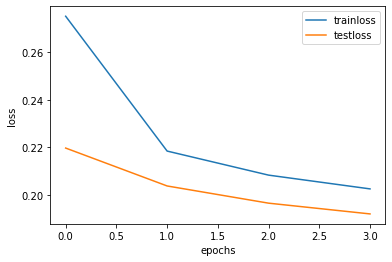

In [2]:
model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer = setup(None)

name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}.pth"
model_dir = "/tmp/models"


stats=list()
for epoch in range(epochs):
    trainloss = train_epoch(model,dataloader,optimizer, criterion, device)
    testmetrics, testloss = test_epoch(model,validdataloader,device, criterion, n_predictions=1)
    metric_msg = ", ".join([f"{name}={metric.compute():.2f}" for name, metric in testmetrics.items()])
    msg = f"epoch {epoch}: train loss {trainloss:.2f}, test loss {testloss:.2f}, {metric_msg}"
    print(msg)

    #test_model(model, validdataset, device)

    model_name = name_pattern.format(region=region, num_layers=num_layers, hidden_size=hidden_size, epoch=epoch)
    pth = os.path.join(model_dir, model_name+".pth")
    print(f"saving model snapshot to {pth}")
    snapshot(model, optimizer, pth)
    stat = dict()
    stat["epoch"] = epoch
    for name, metric in testmetrics.items():
        stat[name]=metric.compute()

    stat["trainloss"] = trainloss.cpu().detach().numpy()
    stat["testloss"] = testloss.cpu().detach().numpy()
    stats.append(stat)

df = pd.DataFrame(stats)

fig,ax = plt.subplots()
ax.plot(df.epoch, df.trainloss, label="trainloss")
ax.plot(df.epoch, df.testloss, label="testloss")
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

## 2. Predict test points with little seen data

We only introduce a single time instance $t=0$ to see what representation the model learns in the absence of data


saving to /tmp/models/model


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e82f04eb8>,
       dtype=object))

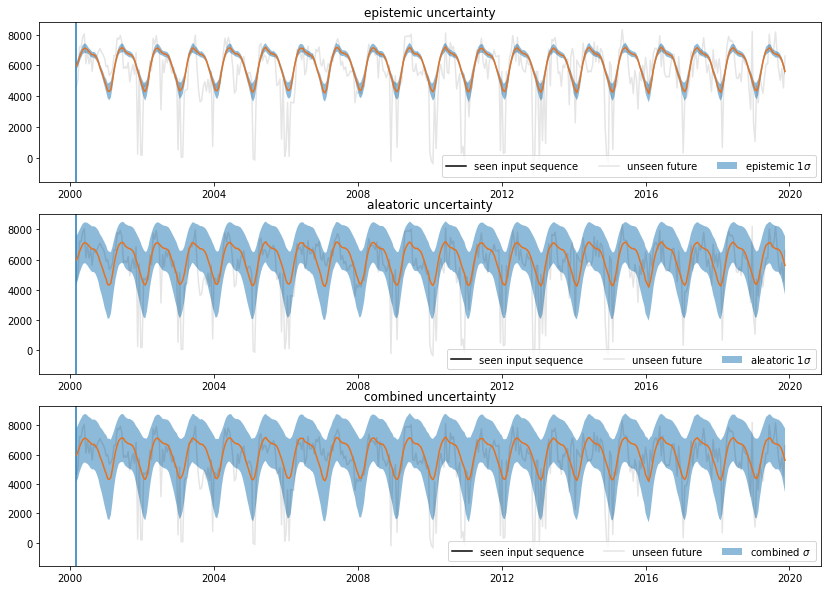

In [3]:
N_seen_points = 1
idx = 10
date = testdataset.date[idx].astype(np.datetime64)
store = "/tmp/models/model"
make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

## 2a) Good Example (idx 10)
Likely represented well in the training dataset.

saving to /tmp/models/model


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e8ca7e080>,
       dtype=object))

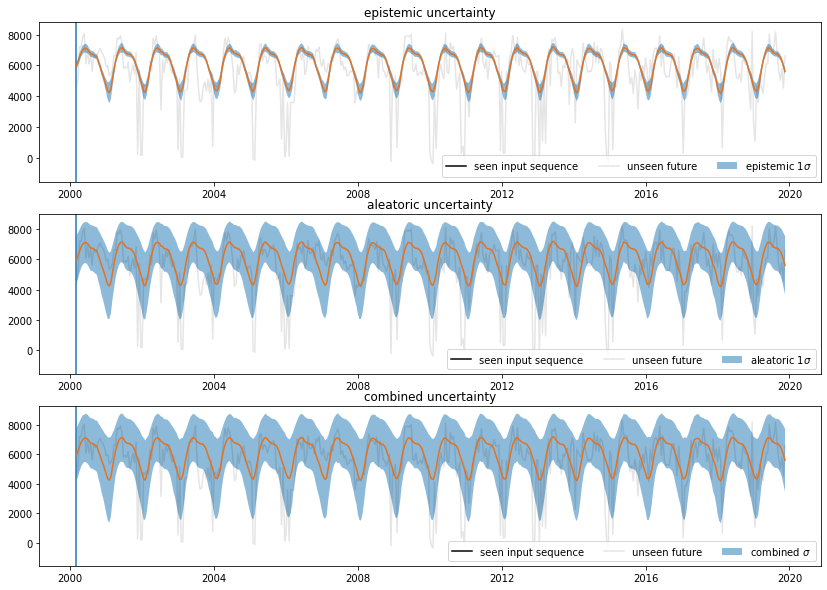

In [4]:
N_seen_points = 1
idx = 10
date = testdataset.date[idx].astype(np.datetime64)
store = "/tmp/models/model"

make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

## 2b) Bad exanoke (idx 17)

Here is one test example that is not well-represented in the training set

The model predicts systematically to low values

saving to /tmp/models/model


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e880c1c50>,
       dtype=object))

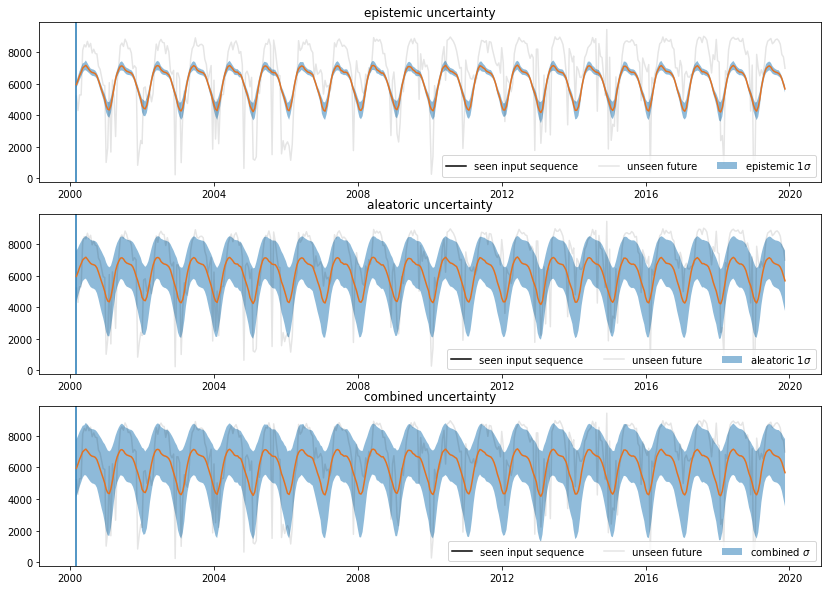

In [5]:
N_seen_points = 1
idx = 17
make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

## Poor Example
Likely out-of-training-distribution. The model predicts systematilly to low values.

All model representations are affected equally. Hence, the epistemic model undertainty is underestimated 

saving to /tmp/models/model


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e7dd67fd0>,
       dtype=object))

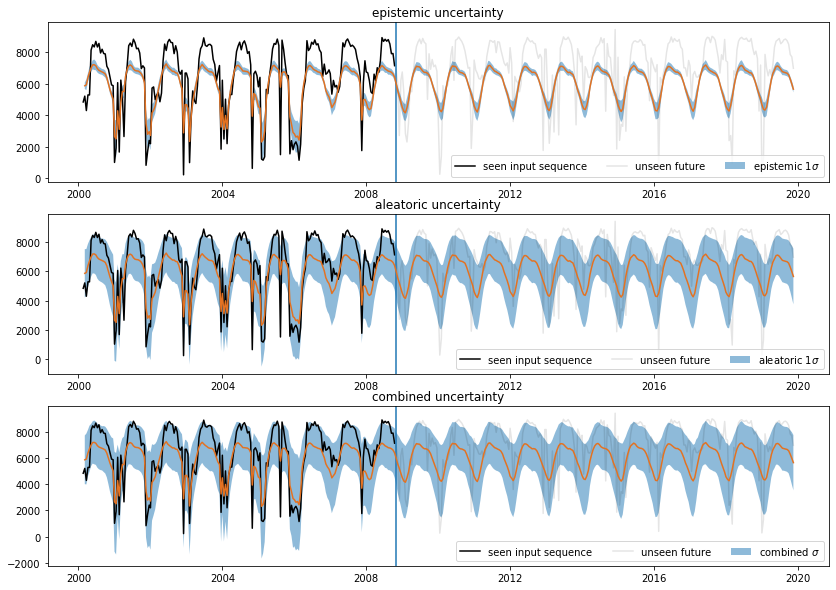

In [6]:
idx = 17
N_seen_points = 200

make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

## 3) Here we compare the estimated prediction to the trained dataset.

We use the sample of idx 17 where we assumed that it is not represented well in the training dataset.
* In the top row, we plot the model prediction with seeing 250 priod datapoints. The model should adjust to this specific example. However, it predicts systematically too low even though it sees 250 data points.
* In the second row we plot the model prediction with seeing only 1 data point. This is similar tot he mean and std of the dataset  (third row)
* In the last row, we compare all means. **We see that the model predicts a similar mean no matter how much data ist sees in the encoding phase!**

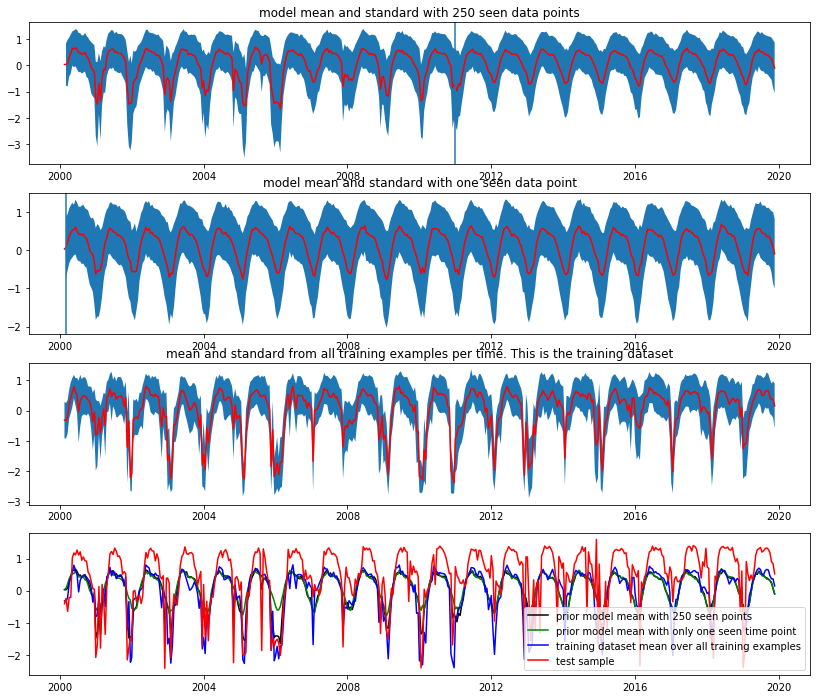

In [7]:
idx = 17
x = testdataset.data[idx].astype(float)

def predict_future(x, date, N_seen_points):
    future = x.shape[0] - N_seen_points
    x_ = torch.Tensor(x)[None, :].to(device)
    if x_.shape[2] == 2:
        doy_seen = x_[:, :N_seen_points, 1]
        doy_future = x_[:, N_seen_points:, 1]
    else:
        doy_seen = None
        doy_future=None
    x_data = x_[:, :N_seen_points, 0].unsqueeze(2)
    mean, epi_var, ale_var,y_hat = model.predict(x_data, 10, future, date=doy_seen, date_future=doy_future, return_yhat=True)
    var = epi_var + ale_var
    mean = mean.cpu().squeeze()
    var = var.cpu().squeeze()
    epi_var = epi_var.cpu().squeeze()
    ale_var = ale_var.cpu().squeeze()
    epi_std = torch.sqrt(epi_var[1:])
    ale_std = torch.sqrt(ale_var[1:])
    data_std = epi_std + ale_std
    return mean, data_std

fig,axs = plt.subplots(4,1,figsize=(14, 12))

ax = axs[0]
N_seen_points=250
mean_half_seen, data_std_half_seen = predict_future(x, date, N_seen_points)
ax.set_title(f"model mean and standard with {N_seen_points} seen data points")
ax.fill_between(date[1:], mean_half_seen[1:]-data_std_half_seen, mean_half_seen[1:]+data_std_half_seen)
ax.plot(date,mean_half_seen,'r')
ax.axvline(date[N_seen_points])

ax = axs[1]
N_seen_points=1
mean, data_std = predict_future(x, date, N_seen_points)
ax.set_title("model mean and standard with one seen data point")
ax.fill_between(date[1:], mean[1:]-data_std, mean[1:]+data_std)
ax.plot(date,mean,'r')
ax.axvline(date[N_seen_points])

ax = axs[2]
ax.set_title("mean and standard from all training examples per time. This is the training dataset")
dataset_mean = dataset.data[:,:,0].mean(0)
dataset_std = dataset.data[:,:,0].std(0)

ax.fill_between(date, dataset_mean-dataset_std, dataset_mean+dataset_std)
ax.plot(date,dataset_mean,'r')

ax = axs[3]
ax.plot(date,mean_half_seen,'k', label="prior model mean with 250 seen points")
ax.plot(date,mean,'g', label="prior model mean with only one seen time point")
ax.plot(date,dataset_mean,'b', label="training dataset mean over all training examples")
ax.plot(date,x[:,0],'r', label="test sample")
ax.legend()